In [32]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Датасет moons

In [33]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

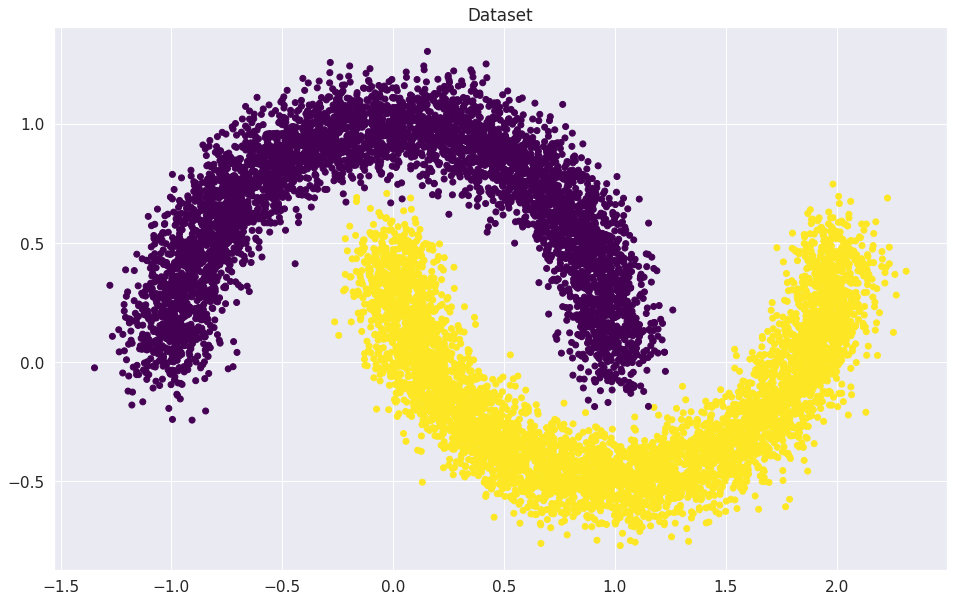

In [34]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

In [36]:
X_train_t =  torch.from_numpy(X_train)
y_train_t =  torch.from_numpy(y_train)
X_val_t =  torch.from_numpy(X_val)
y_val_t =  torch.from_numpy(y_val)

Создаем `Dataset` и `DataLoader`. 

In [37]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Реализация логистической регрессии

In [38]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights.T
        if self.bias:
            x +=  self.bias_term 
        return x

In [39]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Посмотрим на количество обучаемых параметров у получившейся модели

In [40]:
sum(i.numel() for i in linear_regression.parameters())

3

### Train loop

### Реализация цикла обучения

In [41]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch.float())
        loss = loss_function(outp.view(-1), y_batch.float())
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.796875
Iteration: 100
Batch accuracy: 0.84375
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.921875

Iteration: 342.Convergence. Stopping iterations.


### Визуализируем результаты

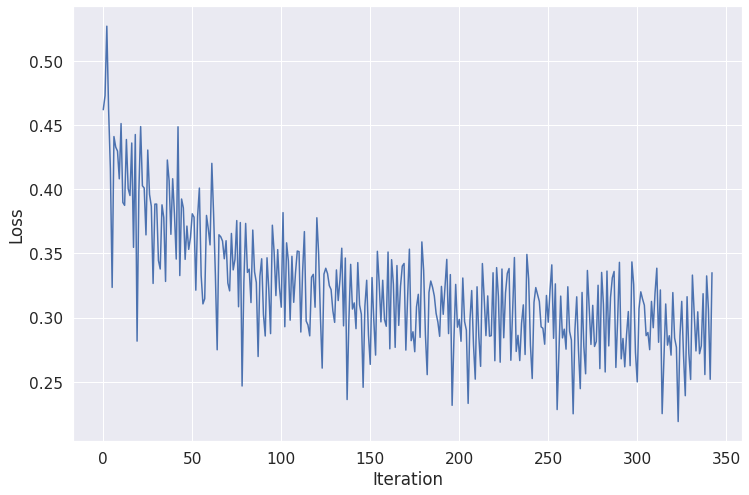

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

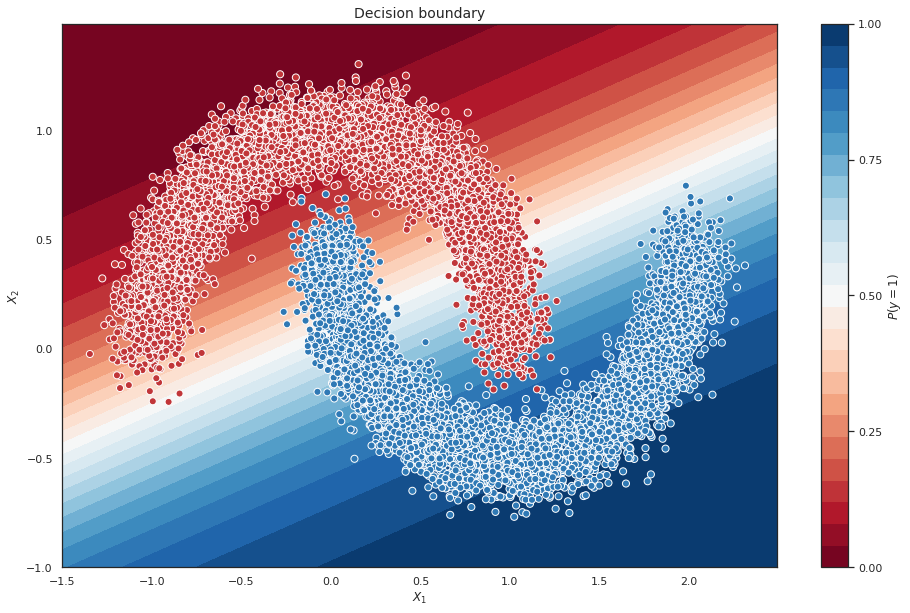

In [43]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Реализуем predict и посчитаем accuracy на test.

In [44]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model.forward(x_batch.float())
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long) 
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [45]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_pred, y_val)

0.8784

# Датасет MNIST

In [46]:
import os
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tfs
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)
batch_size = 128 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

## Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [47]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [48]:
from torchsummary import summary

In [49]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128,128),
    activation(),
    nn.Linear(128,10)
)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

In [52]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model.forward(x_batch)
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad(): 
                    outp = model.forward(x_batch)
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch)
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                optimizer.zero_grad()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8890224358974359
Loader: valid. Accuracy: 0.9269831730769231
Epoch: 2
Loader: train. Accuracy: 0.9497863247863247
Loader: valid. Accuracy: 0.9537259615384616
Epoch: 3
Loader: train. Accuracy: 0.9642427884615384
Loader: valid. Accuracy: 0.9626402243589743
Epoch: 4
Loader: train. Accuracy: 0.9717381143162394
Loader: valid. Accuracy: 0.965645032051282
Epoch: 5
Loader: train. Accuracy: 0.9766125801282052
Loader: valid. Accuracy: 0.9652443910256411
Epoch: 6
Loader: train. Accuracy: 0.9796841613247863
Loader: valid. Accuracy: 0.9672475961538461
Epoch: 7
Loader: train. Accuracy: 0.9826388888888888
Loader: valid. Accuracy: 0.9711538461538461
Epoch: 8
Loader: train. Accuracy: 0.9845753205128205
Loader: valid. Accuracy: 0.9708533653846154
Epoch: 9
Loader: train. Accuracy: 0.9861278044871795
Loader: valid. Accuracy: 0.9701522435897436
Epoch: 10
Loader: train. Accuracy: 0.9866786858974359
Loader: valid. Accuracy: 0.9732572115384616


### Протестируем разные функции активации.

In [53]:
elu_accuracy = accuracy["valid"]

In [54]:
def test_activation_function(activation):
    #YOUR CODE
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128,128),
    activation(),
    nn.Linear(128,10)
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    device = "cuda" if torch.cuda.is_available() else "cpu"

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model.forward(x_batch)
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad(): 
                    outp = model.forward(x_batch)
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch) 
            all =  len(preds) 
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                optimizer.zero_grad()
                optimizer.step()
      accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [55]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

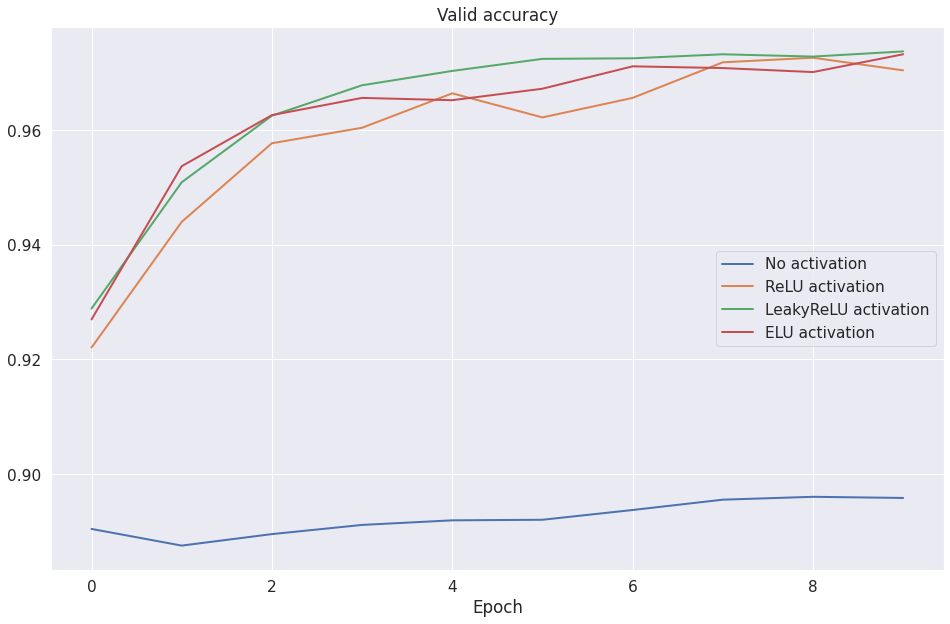

In [56]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

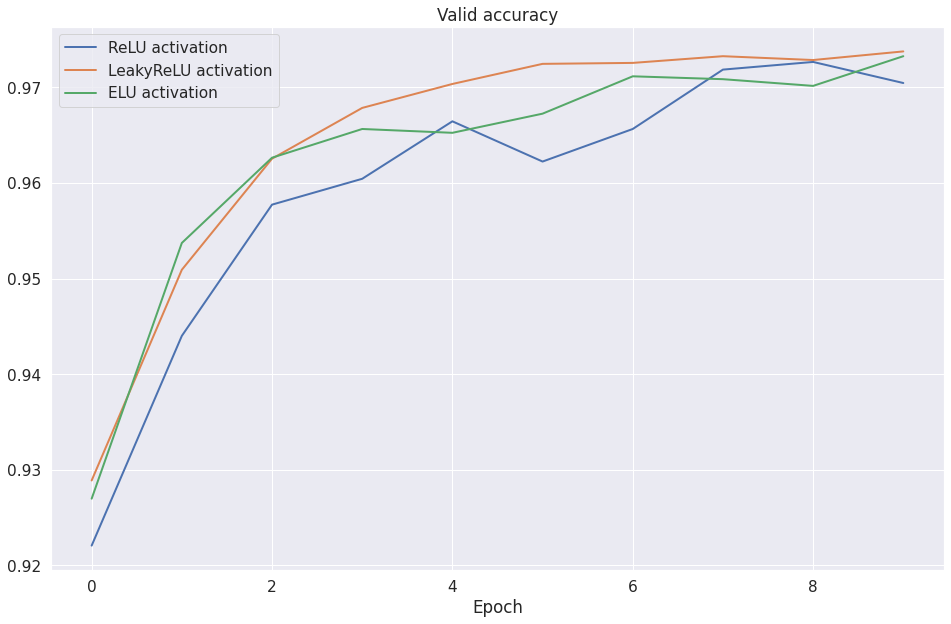

In [57]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [58]:
plain_accuracy[-1], relu_accuracy[-1], elu_accuracy[-1], leaky_relu_accuracy[-1]

(0.8958333333333334,
 0.9704527243589743,
 0.9732572115384616,
 0.9737580128205128)

К концу обучения наивысший accuracy показала leaky_relu


## Сверточные нейронные сети

### Реализация LeNet

In [23]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5 ,120)   
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) 
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучение CNN

In [29]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model.forward(x_batch)
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad(): 
                    outp = model.forward(x_batch)
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch) 
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                optimizer.zero_grad()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9048143696581197
Loader: valid. Accuracy: 0.9698517628205128
Epoch: 2
Loader: train. Accuracy: 0.9744257478632479
Loader: valid. Accuracy: 0.9751602564102564
Epoch: 3
Loader: train. Accuracy: 0.9824719551282052
Loader: valid. Accuracy: 0.9799679487179487
Epoch: 4
Loader: train. Accuracy: 0.9871127136752137
Loader: valid. Accuracy: 0.9817708333333334
Epoch: 5
Loader: train. Accuracy: 0.9900173611111112
Loader: valid. Accuracy: 0.9846754807692307
Epoch: 6
Loader: train. Accuracy: 0.9920038728632479
Loader: valid. Accuracy: 0.9841746794871795
Epoch: 7
Loader: train. Accuracy: 0.9931056356837606
Loader: valid. Accuracy: 0.9831730769230769
Epoch: 8
Loader: train. Accuracy: 0.9940237713675214
Loader: valid. Accuracy: 0.9858774038461539
Epoch: 9
Loader: train. Accuracy: 0.9943576388888888
Loader: valid. Accuracy: 0.9866786858974359
Epoch: 10
Loader: train. Accuracy: 0.9953091613247863
Loader: valid. Accuracy: 0.9864783653846154


In [30]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

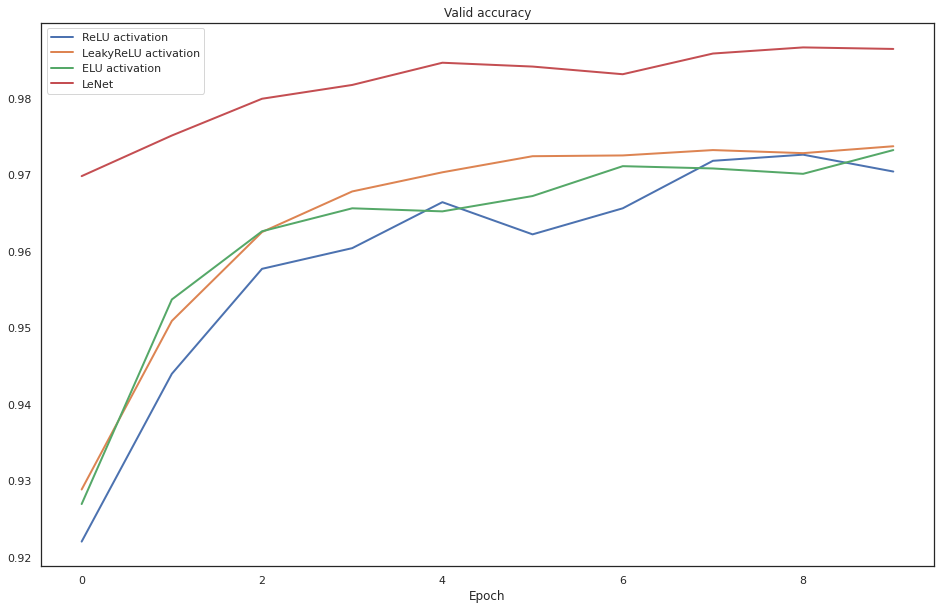

In [62]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()